## <span style="color:green">**Version en cours**</span>

# Segmentez des clients d'un site e-commerce
## Notebook 3 : Tests de modèles de clustering
OpenClassrooms - Parcours Data Scientist - Projet 05  

## Présentation du projet

**Contexte**  


* Olist est une entreprise brésilienne qui propose une solution de vente sur les marketplaces en ligne.  
* Dans un premier temps il est demandé de réaliser quelques requêtes pour le dashboard à partir de la base de données SQLite d'Olist.  
* La mission principale est de fournir aux équipes d'e-commerce d'Olist une **segmentation des clients** qu’elles pourront utiliser au quotidien pour leurs campagnes de communication.

**Démarche globale**  
* Requêtes SQL pour le dashboard (cf Notebook 1)  
* Feature ingineering (cf Notebook 2)
* **Tests de modèles de clustering** : c'est l'objet de ce notebook  
* Simulation d'un contrat de maintenace (Notebbok 4)  

**Tests de modèles de clustering**  
* Objectif :
   * bla bla bla 

## Sommaire  
**Préparation de l'environnement**  
* Environnement virtuel
* Import des modules
* Fonctions
* Chargement du dataset  

**Premier test de clustering via scikit-learn KMeans**  
* Premier test avec 5 clusters
* Détermination du nombre optimal de clusters
* Test avec 7 clusters

**Second test KMeans - Feature `Montant` passée au log**  
* KMeans - 7 clusters  
* KMeans - 4, 5, 6 ou 8 clusters  

**Troisième test KMeans - Feature `Montant` normalisée via QuantileTransformer**  
* Détermination du nombre optimal de clusters
* Entraînement du modèle - 4 clusters
* Entraînement du modèle - 5 clusters

**Quatrième test KMeans - Feature `Montant` classée par tranches**  
* Détermination du nombre optimal de clusters
* KMeans 6 clusters

**Test DBSCAN**  
* Préparation du dataset
* Recherche des hyperparamètres optimaux
* Résultats DBSCAN  

# 1 Préparation de l'environnement

## 1.1 Environnement virtuel

In [1]:
# Vérification environnement virtuel
envs = !conda env list
print(f"Environnement virtuel : {[e for e in envs if '*' in e][0].split('*')[1].strip()}")

Environnement virtuel : C:\Users\chrab\anaconda3\envs\opc5


## 1.2 Import des modules

* Installation conditionnelle des librairies

In [2]:
import sys
import subprocess
import pkg_resources

def install_package(package):
    """Installe une librairie en mode silencieux si elle n'est pas encore installée"""
    try:
        pkg_resources.get_distribution(package)
    except pkg_resources.DistributionNotFound:
        print(f"Installation {package}... ", end='')
        subprocess.check_call([sys.executable, "-m", "pip", "install", package, "--quiet"])
        print(f"Terminé.")
    else:
        print(f"{package} est déjà installé.")

In [3]:
# Installation des librairies
install_package('pandas')
install_package('numpy')
install_package('matplotlib')
install_package('seaborn')
install_package('scikit-learn')
install_package('yellowbrick')

pandas est déjà installé.
numpy est déjà installé.
matplotlib est déjà installé.
seaborn est déjà installé.
scikit-learn est déjà installé.
yellowbrick est déjà installé.


* Import des modules

In [4]:
%matplotlib inline

In [5]:
# Import des modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.neighbors import NearestNeighbors
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

In [6]:
mpl.rcParams["figure.figsize"] = (9,6)

## 1.3 Fonctions

In [7]:
def fit_kmeans(X, k, random_state=0):
    """Instancie un modèle KMeans et renvoit les labels
    Arguments :
    X (DataFrame)      : données
    k (int)            : nombre de clusters
    random_state (int) : seed
    Retour :
    (numpy.ndarray) : labels des clusters
    """
    # Initialisation du modèle
    kmeans = KMeans(n_clusters=k, random_state=0)
    # Entraînement du modèle
    kmeans.fit(X)

    return kmeans.labels_

In [8]:
def plot_kelbowvisualizer_kmeans(random_state=0, k=(3, 11), metric='distortion', X=None):
    """Affiche le graphique KElbowVisualizer d'un modèle KMeans permettant la recherche du nombre optimal de clusters
    Elbow Method (metric='distorion') ou Calinski-Harabasz (metric='Calinski-Harabasz')
    Arguments :
        random_state (int) : seed
        k (tuple)          : (min, max+1)
        metric (str)       : 'distortion' par défaut (somme des distances au carré de chaque point à son centre de cluster)
        X (DataFrame)      : dataset d'input
    """
    
    # Instanciation du modèle et du visualiseur
    kmeans = KMeans(random_state=random_state)
    visualizer = KElbowVisualizer(
        kmeans,
        k=k,
        metric=metric
    )
    
    # Alimentation du visualiseur
    visualizer.fit(X)
    
    # Visualisation
    visualizer.finalize()

    return

In [9]:
def display_silhouette_scores(X, random_state=0, k_values=range(3, 11)):
    """Affiche les scores de silhouette d'un modèle KMeans pour la recherche du nombre optimal de clusters
    Renvoit le nombre de clusters ayant obtenu le meilleur score
    Arguments :
        X (DataFrame)      : dataset d'input
        random_state (int) : seed
        k (range)          : plage de k à tester
    Retour :
        silhouette_k (int) : nombre de clusters du meilleur score
    """
    silhouette_scores = []
    silhouette_best_score, silhouette_k = -1, -1
    
    # Calcul des scores de silhouette pour chaque valeur de k
    for k in k_values:
        kmeans = KMeans(n_clusters=k, random_state=random_state)
        kmeans.fit(X)
        silhouette_avg = silhouette_score(X, kmeans.labels_)
        silhouette_scores.append(silhouette_avg)
        if silhouette_avg > silhouette_best_score:
            silhouette_best_score = silhouette_avg
            silhouette_k = k
            
    # Affichage du tableau des scores
    df_silhouette_scores = pd.DataFrame({'k': k_values, 'Score de Silhouette': silhouette_scores}).set_index('k')
    display(df_silhouette_scores.sort_values('Score de Silhouette', ascending=False))
    
    return silhouette_k

In [10]:
def plot_silhouettevisualizer(X, k):
    """Affiche le graphique SilhouetteVisualizer d'un modèle KMeans
    Arguments :
    X (DataFrame) : données
    k (int)       : nombre de clusters
    """
    # Instanciation du modèle KMeans
    model = KMeans(k)
    # Instanciation du visualiseur
    visualizer = SilhouetteVisualizer(model)
    # Alimentation du visualiseur
    visualizer.fit(X)
    # Visualisation du graphique
    visualizer.finalize() 

In [221]:
def plot_elbow_nearest_neighbors(X, k=5):
    """Affiche la courbe distances / indices qui permet de visualiser la valeur d'epsilon du modèle DBSCAN
    en fonction du nombre d'observations du dataframe fourni.
    Arguments:
    X (DataFrame) : features pour DBSCAN
    k (int)       : nombre de points voisins à prendre en considération pour le calcul de la distance
    Retour:
    distance_max  : distance maximum entre un point et ses k plus proches voisins (= epsilon max)
    """
    # Instanciation
    nearest_neighbors = NearestNeighbors(n_neighbors=5)
    # Alimentation du modèle
    neighbors = nearest_neighbors.fit(X)
    # Récupération des distances et indices des points observés
    distances, indices = neighbors.kneighbors(X)
    # Tri par distance pour le graphique
    distances = np.sort(distances, axis=0)
    distances = distances[:,1]
    # Distance maximale
    max_distance = max(distances)
    
    # Affichage de la courbe distances / indices
    plt.figure(figsize=(6, 4))
    plt.plot(distances)   
    plt.title("Méthode du coude pour optimiser le choix d'epsilon")
    plt.xlabel("Echantillon (10 % des observations)")
    plt.ylabel("Distance au plus proches voisins")
    plt.show()
    
    return max_distance

In [206]:
def fit_dbscan(X, epsilon, min_samples):
    """Applique l'algorithme DBSCAN sur le dataset fourni
    Arguments :
    X (dataframe) : dataframe contenant les features
    eps (float)   : hyperparamètre 'eps' de DBSCAN (distance maximale entre 2 points d'un même cluster)
    min_samples   : hyperparamètre 'min_samples' de DBSCAN (nombre de points minimum pour constituer un cluster)
    Retour :
    n_clusters_ (int) : nombre estimé de clusters
    n_noise_ (int)    : nombre estimé de points de bruits
    labels (ndarray)  : tableau des labels des clusters
    """
    # Fit du modèle DBSCAN
    dbscan = DBSCAN(eps=epsilon, min_samples=min_samples).fit(X)
    # Récupération des étiquettes des clusters
    labels = dbscan.labels_
    # Nombre de labels uniques (= nombre de clusters), en ignorant les éventuels points de bruit
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    # Nombre de points de bruits
    n_noise_ = list(labels).count(-1)

    return n_clusters_, n_noise_, labels

## 1.4 Chargement des données

In [11]:
# Chargement 'df_features'
df_features = pd.read_csv('df_features.csv')

In [12]:
# Affichage des premières et dernières lignes
df_features

,Id client,Récence_orig,Fréquence_orig,Montant_orig,Récence,Fréquence,Montant
0,0000366f3b9a7992bf8c76cfdf3221e2,113,0,141.90,0.184692,0,0.009690
1,0000b849f77a49e4a4ce2b2a4ca5be3f,116,0,27.19,0.189684,0,0.001289
2,0000f46a3911fa3c0805444483337064,539,0,86.22,0.893511,0,0.005612
3,0000f6ccb0745a6a4b88665a16c9f078,323,0,43.62,0.534110,0,0.002492
4,0004aac84e0df4da2b147fca70cf8255,290,0,196.89,0.479201,0,0.013717
...,...,...,...,...,...,...,...
95116,fffcf5a5ff07b0908bd4e2dbc735a684,449,0,2067.42,0.743760,0,0.150707
95117,fffea47cd6d3cc0a88bd621562a9d061,264,0,84.58,0.435940,0,0.005492
95118,ffff371b4d645b6ecea244b27531430a,570,0,112.46,0.945092,0,0.007534
95119,ffff5962728ec6157033ef9805bacc48,121,0,133.69,0.198003,0,0.009089


# 2 Premier test de clustering via scikit-learn KMeans

## 2.0 Premier test avec 5 clusters

In [13]:
# Nombre de clusters
k = 5

In [14]:
# Sélection des features
X = df_features[['Récence', 'Fréquence', 'Montant']]

In [15]:
# Entrainement du modèle
labels = fit_kmeans(X, k, random_state=0)

In [16]:
# Ajout des labels de cluster à 'df_features'
df_features['Cluster'] = labels

In [17]:
# Affichage du résultat
display(df_features)

,Id client,Récence_orig,Fréquence_orig,Montant_orig,Récence,Fréquence,Montant,Cluster
0,0000366f3b9a7992bf8c76cfdf3221e2,113,0,141.90,0.184692,0,0.009690,2
1,0000b849f77a49e4a4ce2b2a4ca5be3f,116,0,27.19,0.189684,0,0.001289,2
2,0000f46a3911fa3c0805444483337064,539,0,86.22,0.893511,0,0.005612,4
3,0000f6ccb0745a6a4b88665a16c9f078,323,0,43.62,0.534110,0,0.002492,3
4,0004aac84e0df4da2b147fca70cf8255,290,0,196.89,0.479201,0,0.013717,3
...,...,...,...,...,...,...,...,...
95116,fffcf5a5ff07b0908bd4e2dbc735a684,449,0,2067.42,0.743760,0,0.150707,4
95117,fffea47cd6d3cc0a88bd621562a9d061,264,0,84.58,0.435940,0,0.005492,0
95118,ffff371b4d645b6ecea244b27531430a,570,0,112.46,0.945092,0,0.007534,4
95119,ffff5962728ec6157033ef9805bacc48,121,0,133.69,0.198003,0,0.009089,2


,Cluster,Id client,%
0,0,30627,32.20
1,1,2900,3.05
2,2,29719,31.24
3,3,18451,19.40
4,4,13424,14.11


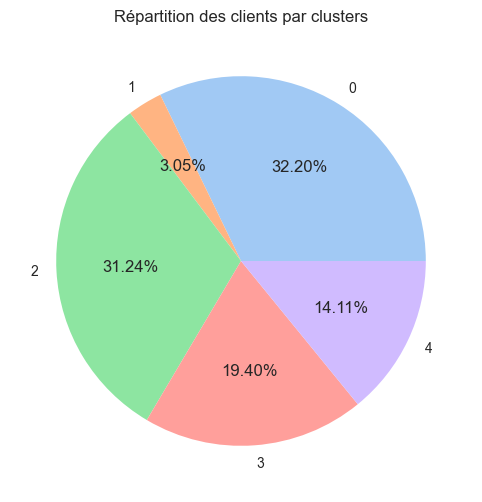

In [18]:
# Nombre de clients par clusters
df_number_of_customers_by_clusters = df_features.groupby('Cluster')['Id client'].count().reset_index()

# Ajout pourcentages
number_of_customers = df_features.shape[0]
df_number_of_customers_by_clusters['%'] = round((df_number_of_customers_by_clusters['Id client'] / number_of_customers) * 100, 2)
display(df_number_of_customers_by_clusters)

# Graphique de répartition
colors = sns.color_palette('pastel')[0:5]
plt.title('Répartition des clients par clusters')
plt.pie(df_number_of_customers_by_clusters['Id client'], labels=df_number_of_customers_by_clusters['Cluster'], colors = colors, autopct='%.2f%%')
plt.show()

* Le modèle segmente bien les clients en **5 clusters** 
* Chaque segment représente **entre 3 et 32 % des clients**

## 2.1 Détermination du nombre optimal de clusters

### 2.1.1 Méthode du Coude (Elbow Method)

* Cette méthode consiste à tracer le pourcentage de variance expliquée en fonction du nombre de clusters.  
* Le point où l'ajout de clusters supplémentaires ne donne pas de meilleure explication des données permet de déterminer le nombre optimal de clusters. Ce point ressemble souvent à un "coude" sur le graphique.  
* La bibliothèque `yellowbrick` propose des outils de visualisation pour la méthode du coude

* Graphique KElbowVisualizer pour un nombre de clusters **k** compris entre 3 et 10

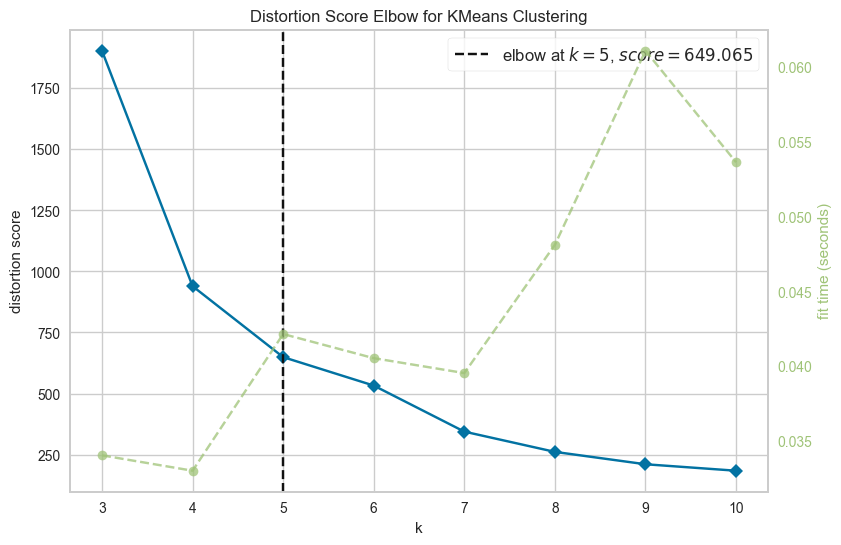

In [19]:
# Graphique KElbowVisualizer Elbow Method, k compris entre 3 et 10
plot_kelbowvisualizer_kmeans(random_state=0, k=(3, 11), metric='distortion', X=X)

* **Avant k=5** : chaque augmentation de k entraîne une amélioration significative de la performance du clustering (mesurée par une forte diminution de la distorsion), la pente de la courbe bleue est importante  
* **Après k=5** : la courbe commence à s'aplatir, les bénéfices de l'ajout de clusters supplémentaires diminuent, l'ajout de clusters supplémentaires n'apporte pas d'amélioration proportionnelle de la performance
* **k=5** : c'est le nombre de clusters optimal selon cette méthode
* Le score de **649.065** représente la valeur de distorsion (somme des distances au carré de chaque point à son centre de cluster) pour **k=5**

* Le coude n'est pas franchement marqué, d'autres méthodes pourront confirmer ou infirmer le choix de 5 clusters
* Remarque : la pente de la courbe redevient un peu plus forte entre 6 et 7 clusters, choisir 7 clusters serait-il pertinent ?

### 2.1.2 Methode du Score de Silhouette

* Le score de silhouette calcule la distance entre les clusters ainsi que la cohésion au sein des clusters :  
   * Soit $a$ la distance moyenne d'un point avec les autres points du même cluster  
   * Soit $b$ la distance moyenne d'un point aves les clusters les plus proches  
   * La différence $a-b$, si elle est positive, indique que le point est bien positionné dans son cluster  
   * Si elle est négative, le point est situé dans un cluster voisin  
   * Plus cette différence est proche de 0, plus le point se situe à la limite de 2 clusters
   * Le ratio $\frac{a-b}{max(a, b)}$ est le coefficient de silhouette du point
   * La moyenne de tous les coefficients de silhouettes est le score de sihhouette, indiquant la qualité de la segmentation
* Un score plus élevé indique une meilleure définition des clusters
* La bibliothèque `yellowbrick` propose des outils de visualisation pour cette méthode

#### 2.1.2.1 Calcul des scores de silhouette

* Comme pour la méthode du coude, recherche du meilleur score de silhouette pour **k** compris entre 1 et 10

In [20]:
# Affichage du tableau des scores de silhouette pour k compris ente 3 et 10
silhouette_k = display_silhouette_scores(X, random_state=0, k_values=range(3, 11))

,Score de Silhouette
k,
3,0.597566
4,0.575646
7,0.547662
5,0.543333
8,0.542496
6,0.539311
9,0.537341
10,0.522042


* Le meilleur score de silhouette (**0.598**) est obtenu lorsque KMeans segmente les clients en **3** clusters
* Cette segmentation semble peu pertinente du point de vue métier, Olist attend un plus grand nombre de groupes de clients

#### 2.1.2.2 Visualisation

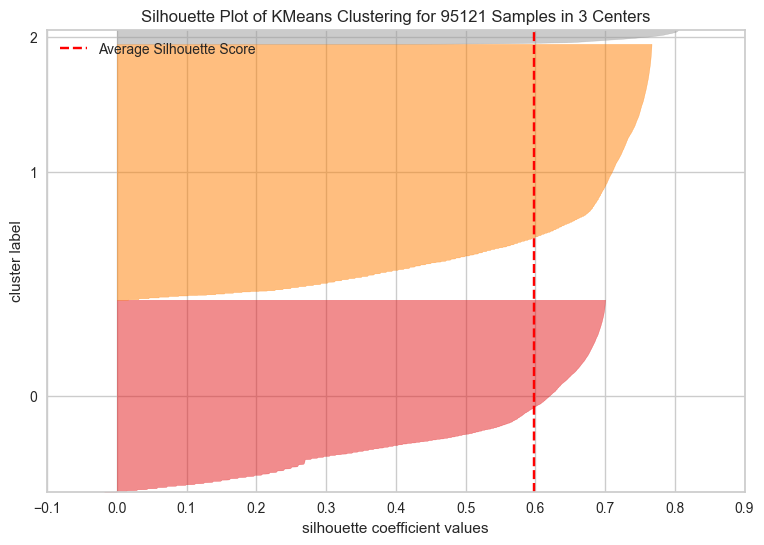

In [21]:
# Affichage SilhouetteVisualizer
plot_silhouettevisualizer(X, silhouette_k)

* Le nombre de clients n'est pas uniformément réparti, le cluster 2 (gris) contient beucoup moins de points
* La moyenne des coefficients de silhouette est très proche de **0.6**, la qualité de clustering semble relativement bonne  
* Aucun coefficient n'est négatif, signe qu'aucun client n'a été mal positionné  

### 2.1.3 Méthode Calinski-Harabasz (score du rapport variance)

* Mesure à quel point les points sont proches les uns des autres au sein de chaque cluster
* Évalue à quel point les clusters sont éloignés les uns des autres
* Un score élevé indique un clustering mieux défini  

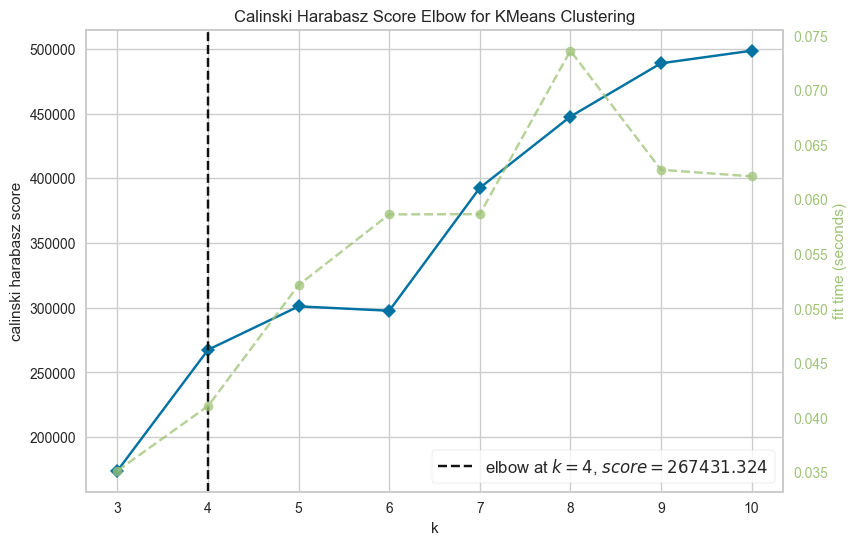

In [22]:
# Graphique KElbowVisualizer Calinski-Harabasz, k compris entre 3 et 10
plot_kelbowvisualizer_kmeans(random_state=0, k=(3, 11), metric='calinski_harabasz', X=X)

* Avec une pente qui augmente moins fortement entre 5 et 6 clusters, la méthode Calinski Harabasz préconise une **segmentation en 4 clusters** 
* Les scores obtenus avec une segmentation en 7, 8 ou 9 clusters semblent aussi intéressants puisque leurs scores augmentent de manière significative
* Le passage de 9 à 10 clusters ne semble pas apporter d'amélioration proportionnellement parlant

### 2.1.4 Nombre de clusters retenus

* Les différentes méthodes testées donnent des résultats différents :
| Méthode              | Nombre de clusters (k) | 
|----------------------|------------------------|  
| Elbow Method         | **5**                  |  
| Score de Silhouette  | **3**                  |  
| Calinski Harabasz    | **4**                  |
* Les courbes des graphiques Elbow Method et Calinski Harabasz laissent présumer qu'une segmentation en **7** clusters pourrait étre intéressante

* Visualisation de la méthode des scores de silhouette avec **k=7**

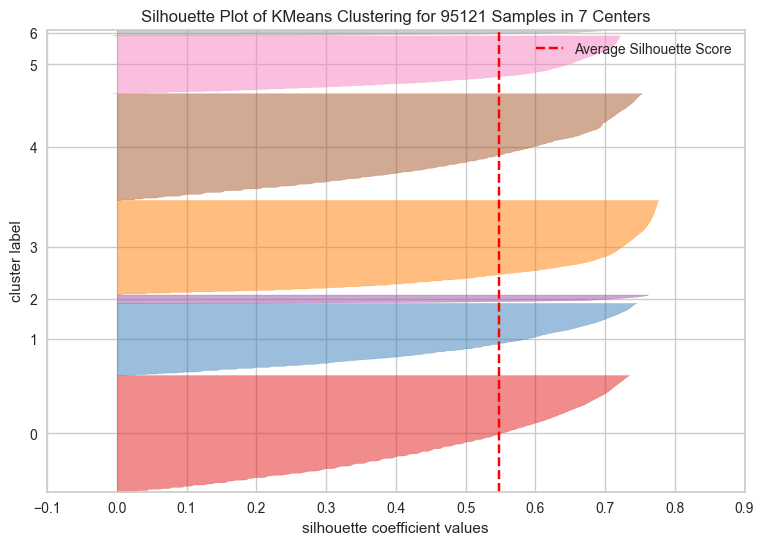

In [23]:
# Affichage SilhouetteVisualizer
plot_silhouettevisualizer(X, 7)

* La moyenne des coefficients de silhouette est d'environ **0.55**
* Les clusters 2 et 6 sont largement moins peuplés
* Les coefficients sont positifs : il n'y a pas de chevauchement entre les clusters  

## 2.2 Test KMeans avec 7 clusters

### 2.2.1 Entrainement du modèle

In [24]:
# Entrainement du modèle et ajout des labels de clusters à 'df_features
df_features['Cluster'] = fit_kmeans(X, 7, random_state=0)

### 2.2.2 Affichage des résultats

In [25]:
# Affichage du résultat
display(df_features)

,Id client,Récence_orig,Fréquence_orig,Montant_orig,Récence,Fréquence,Montant,Cluster
0,0000366f3b9a7992bf8c76cfdf3221e2,113,0,141.90,0.184692,0,0.009690,2
1,0000b849f77a49e4a4ce2b2a4ca5be3f,116,0,27.19,0.189684,0,0.001289,2
2,0000f46a3911fa3c0805444483337064,539,0,86.22,0.893511,0,0.005612,4
3,0000f6ccb0745a6a4b88665a16c9f078,323,0,43.62,0.534110,0,0.002492,3
4,0004aac84e0df4da2b147fca70cf8255,290,0,196.89,0.479201,0,0.013717,0
...,...,...,...,...,...,...,...,...
95116,fffcf5a5ff07b0908bd4e2dbc735a684,449,0,2067.42,0.743760,0,0.150707,4
95117,fffea47cd6d3cc0a88bd621562a9d061,264,0,84.58,0.435940,0,0.005492,0
95118,ffff371b4d645b6ecea244b27531430a,570,0,112.46,0.945092,0,0.007534,4
95119,ffff5962728ec6157033ef9805bacc48,121,0,133.69,0.198003,0,0.009089,2


### 2.2.3 Analyse des clusters

#### 2.2.3.1 Répartition des clients par cluster

,Cluster,Id client,%
0,0,21979,23.11
1,1,1747,1.84
2,2,24005,25.24
3,3,14857,15.62
4,4,11919,12.53
5,5,1153,1.21
6,6,19461,20.46


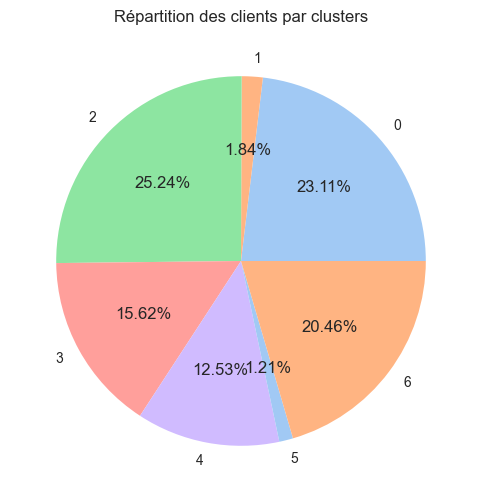

In [26]:
# Nombre de clients par clusters
df_number_of_customers_by_clusters = df_features.groupby('Cluster')['Id client'].count().reset_index()

# Ajout pourcentages
number_of_customers = df_features.shape[0]
df_number_of_customers_by_clusters['%'] = round((df_number_of_customers_by_clusters['Id client'] / number_of_customers) * 100, 2)
display(df_number_of_customers_by_clusters)

# Graphique de répartition
colors = sns.color_palette('pastel')[0:5]
plt.title('Répartition des clients par clusters')
plt.pie(df_number_of_customers_by_clusters['Id client'], labels=df_number_of_customers_by_clusters['Cluster'], colors = colors, autopct='%.2f%%')
plt.show()

* La répartition est relativement homogène, à l'exception des clusters 1 et 5 beaucoup moins peuplés (le Silhouette plot montrait aussi 2 clusters de très faible taille)
* Sous réserve qu'il y ait un sens métier, cette répartition n'est pas génante

#### 2.2.3.2 Distributions des features par cluster

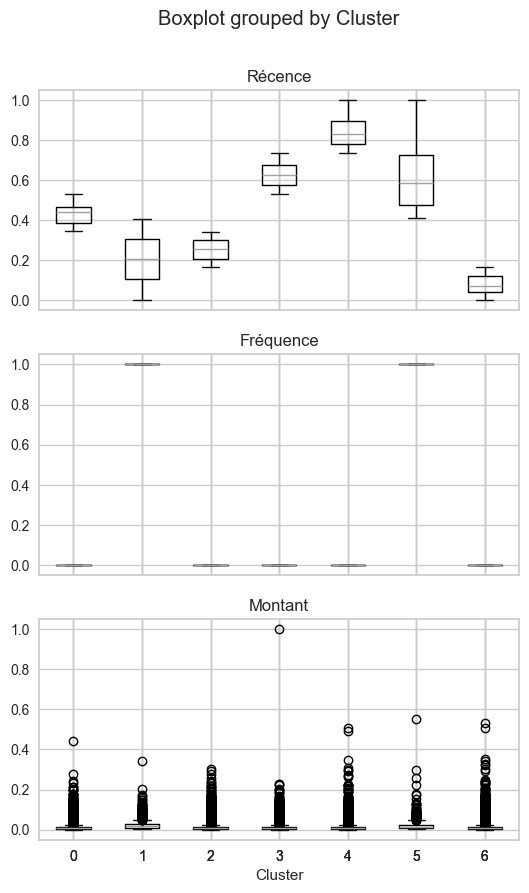

In [27]:
# Boxplots 
boxplots = df_features.boxplot(column=['Récence', 'Fréquence', 'Montant'], by='Cluster', grid=True, figsize=(6, 10), layout=(3, 1))

* Les clusters 1 et 5 se distinguent facilement par une `Fréquence` à 1 (clients ayant passé plus d'une commande) avec une `Récence` plus faible pour le cluster 1 que pour le 5, sans chevauchement
* Si on fait abstraction des boxplots `Récence` des clusters 1 et 5, il n'y a pas chevauchement, le clustering se fait bien au niveau de cette feature
* La feature `Montant` n'est pas interprétable en l'état, les boxplots se chevauchent et montrent de nombreuses valeurs aberrantes. Il est particulièrement difficile d'analyser la segmentation par montants.

### 2.2.4 Conclusions du test

#### 2.2.4.1 Constat

* KMeans ne peut segmenter correctement le dataset compte-tenu de la feature `Montant`
* Les boxplots de cette variable pour chaque cluster montrent des distributions fortement asymétriques, avec de nombreux outliers
* Le boxplot de la variable d'origine montre une distribution similaire :

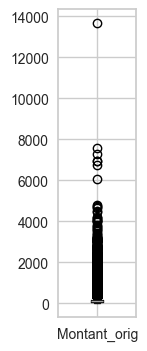

In [28]:
# Distribution `Montant_orig`
boxplot = df_features.boxplot(column='Montant_orig', grid=True, figsize=(1, 4))

#### 2.2.4.2 Pistes

Il semble pertinent de transformer la variable `Montant` de manière à ce que sa distribution soit exploitable par le modèle.
* Utiliser une technique de mise à l'échelle robuste aux outliers (RobustScaler) ?
* Passer la variable au log ?
* Utiliser le coefficient de variation (Montant / moyenne des montants) ?

* Ces pistes sont explorées dans le **"Notebook 2 - Feature ingineering"**, partie **"5 Feature ingineering variable `Montant`"**

# 3 Second test KMeans - Feature `Montant` passée au log

* Suite à la problématique de la forte asymétrie de la feature `Montant`, cette variable a été passée au log, et un nouveau jeu de données a été généré

In [29]:
# Chargement du nouveau dataset
df_features = pd.read_csv('df_features_2.csv')
df_features['Montant'] = df_features['Montant_log']

## 3.1 Détermination du nombre optimal de clusters

### 3.1.1 Elbow Method

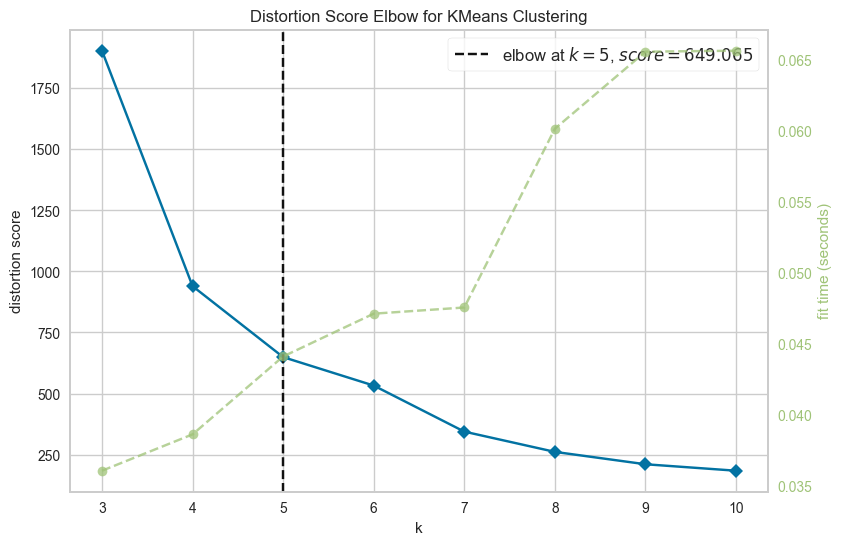

In [30]:
# Graphique KElbowVisualizer Calinski-Harabasz, k compris entre 3 et 10
plot_kelbowvisualizer_kmeans(random_state=0, k=(3, 11), metric='distortion', X=X)

* Le résultat est identique a celui obtenu avant passage au log

### 3.1.2 Scores de Silhouette

In [31]:
# Affichage du tableau des scores de silhouette pour k compris ente 3 et 10
silhouette_k = display_silhouette_scores(X, random_state=0, k_values=range(3, 11))

,Score de Silhouette
k,
3,0.597566
4,0.575646
7,0.547662
5,0.543333
8,0.542496
6,0.539311
9,0.537341
10,0.522042


* Le résultat est aussi strictement identique à celui obtenu avant transformation logarithmique : le meilleur score de silhouette (**0.598**) est obtenu lorsque KMeans segmente les clients en **3** clusters

### 3.1.3 Calinski-Harabasz

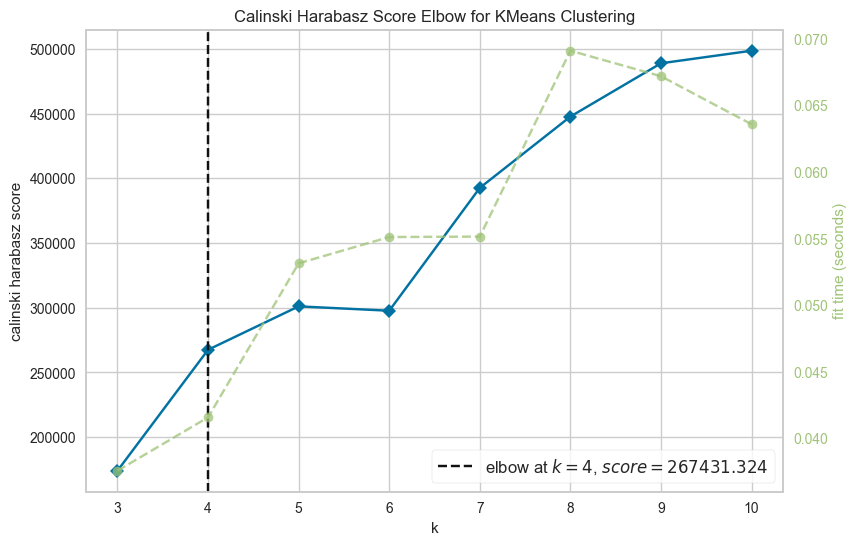

In [32]:
# Graphique KElbowVisualizer Calinski-Harabasz, k compris entre 3 et 10
plot_kelbowvisualizer_kmeans(random_state=0, k=(3, 11), metric='calinski_harabasz', X=X)

* Sans surprise maintenant, la méthode de Calinski Harabasz préconise une segmentation en **4** clusters

## 3.2 KMeans - 7 clusters

* Les différentes méthodes testées donnent des résultats différents :
| Méthode              | Nombre de clusters (k) | 
|----------------------|------------------------|  
| Elbow Method         | **5**                  |  
| Score de Silhouette  | **3**                  |  
| Calinski Harabasz    | **4**                  |
* Les courbes des graphiques Elbow Method et Calinski Harabasz laissent présumer qu'une segmentation en **7 clusters** pourrait étre intéressante

### 3.2.1 Entrainement du modèle

In [33]:
# Entrainement du modèle et ajout des labels de clusters à 'df_features'
df_features['Cluster'] = fit_kmeans(X, 7, random_state=0)

### 2.2.2 Affichage des résultats

In [34]:
# Affichage du résultat
display(df_features)

,Id client,Récence_orig,Fréquence_orig,Montant_orig,Récence,Fréquence,Montant,Montant_log,Montant_qt,Cluster
0,0000366f3b9a7992bf8c76cfdf3221e2,113,0,141.90,0.184692,0,0.363304,0.363304,0.636131,2
1,0000b849f77a49e4a4ce2b2a4ca5be3f,116,0,27.19,0.189684,0,0.136688,0.136688,0.021178,2
2,0000f46a3911fa3c0805444483337064,539,0,86.22,0.893511,0,0.294376,0.294376,0.398488,4
3,0000f6ccb0745a6a4b88665a16c9f078,323,0,43.62,0.534110,0,0.200801,0.200801,0.118413,3
4,0004aac84e0df4da2b147fca70cf8255,290,0,196.89,0.479201,0,0.408757,0.408757,0.777711,0
...,...,...,...,...,...,...,...,...,...,...
95116,fffcf5a5ff07b0908bd4e2dbc735a684,449,0,2067.42,0.743760,0,0.736404,0.736404,0.993256,4
95117,fffea47cd6d3cc0a88bd621562a9d061,264,0,84.58,0.435940,0,0.291726,0.291726,0.388941,0
95118,ffff371b4d645b6ecea244b27531430a,570,0,112.46,0.945092,0,0.331096,0.331096,0.518331,4
95119,ffff5962728ec6157033ef9805bacc48,121,0,133.69,0.198003,0,0.355043,0.355043,0.605161,2


### 3.2.3 Analyse des clusters

#### 3.2.3.1 Répartition des clients par cluster

,Cluster,Id client,%
0,0,21979,23.11
1,1,1747,1.84
2,2,24005,25.24
3,3,14857,15.62
4,4,11919,12.53
5,5,1153,1.21
6,6,19461,20.46


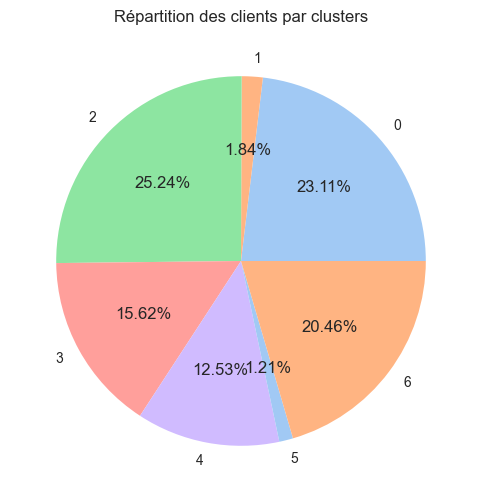

In [35]:
# Nombre de clients par clusters
df_number_of_customers_by_clusters = df_features.groupby('Cluster')['Id client'].count().reset_index()

# Ajout pourcentages
number_of_customers = df_features.shape[0]
df_number_of_customers_by_clusters['%'] = round((df_number_of_customers_by_clusters['Id client'] / number_of_customers) * 100, 2)
display(df_number_of_customers_by_clusters)

# Graphique de répartition
colors = sns.color_palette('pastel')[0:5]
plt.title('Répartition des clients par clusters')
plt.pie(df_number_of_customers_by_clusters['Id client'], labels=df_number_of_customers_by_clusters['Cluster'], colors = colors, autopct='%.2f%%')
plt.show()

* La répartition semble plus homogène après trnasformation logarithmique de la variable `Montant`, avec maintenant 1 seul cluster moins peuplé  

#### 3.2.3.2 Distributions des features par cluster

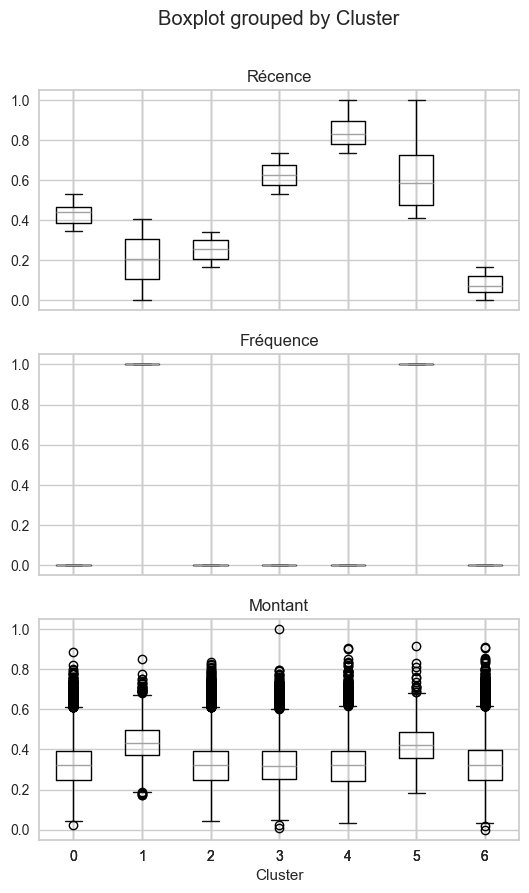

In [36]:
# Boxplots 
boxplots = df_features.boxplot(column=['Récence', 'Fréquence', 'Montant'], by='Cluster', grid=True, figsize=(6, 10), layout=(3, 1))

* Hormis pour la feature `Fréquence`, les boxplots se chevauchent, indiquant des clients à cheval entre plusieurs cluster
* C'est particulièrement le cas au niveau de la feature `Montant`

* La transformation logarithmique de la feature `Montant` n'est pas concluante.

## 3.3 KMeans avec 4, 5, 6 ou 8 clusters

* Tests de répartition des montants entre les clusters, pour 4, 5, 6 ou 8 clusters

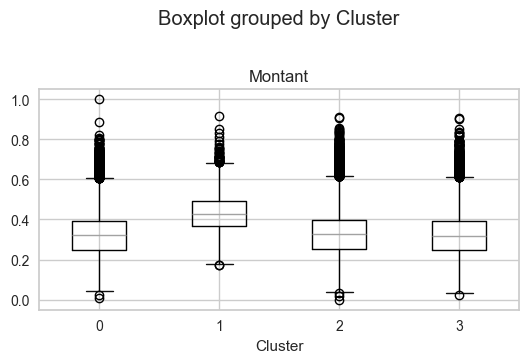

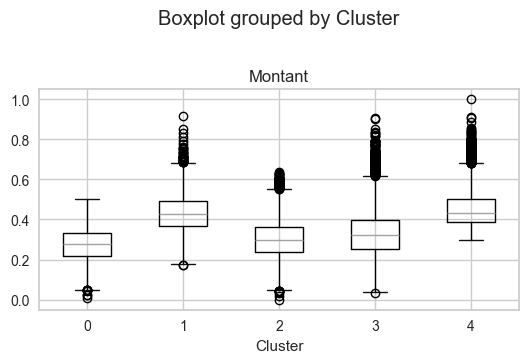

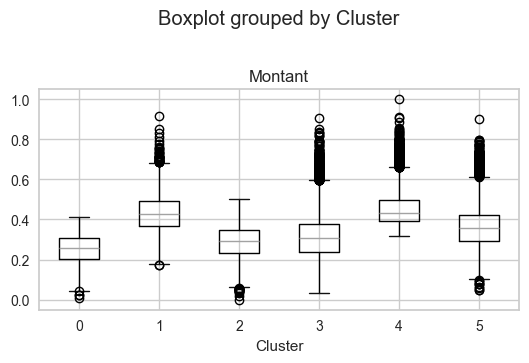

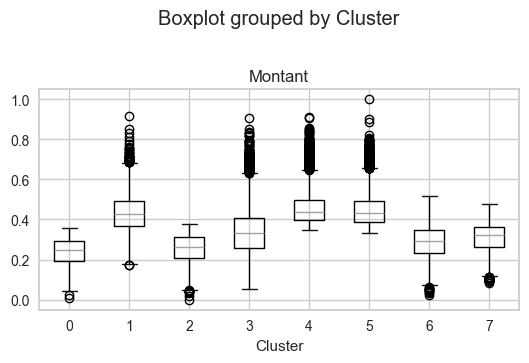

In [37]:
X = df_features[['Récence', 'Fréquence', 'Montant']]

for k in (4, 5, 6, 8):
    df_features['Cluster'] = fit_kmeans(X, k, random_state=0)
    boxplots = df_features.boxplot(column='Montant', by='Cluster', grid=True, figsize=(6, 10), layout=(3, 1))

* Le nombre de clusters semble ne pas avoir d'influence, les chevauchements persistent
* Ces tests confirment les mauvais résultats obtenus après transformation logarithmique de la varianle `Montant`

# 4 Troisième test KMeans - Feature `Montant` normalisée via QuantileTransformer

In [38]:
# Chargement du nouveau dataset
df_features = pd.read_csv('df_features_2.csv')
df_features['Montant'] = df_features['Montant_qt']

## 4.1 Détermination du nombre optimal de clusters

### 4.1.1 Elbow Method

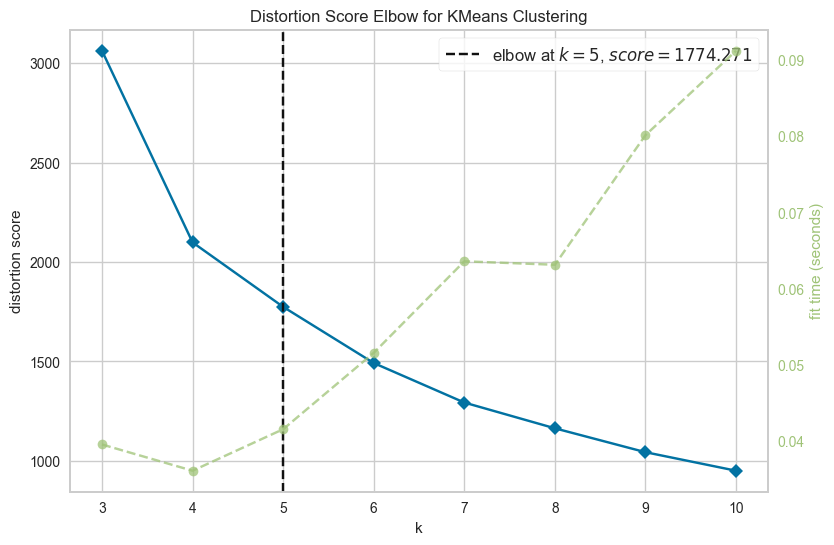

In [39]:
# Graphique KElbowVisualizer Calinski-Harabasz, k compris entre 3 et 10
plot_kelbowvisualizer_kmeans(random_state=0, k=(3, 11), metric='distortion', X=X)

### 4.1.2 Scores de Silhouette

In [40]:
# Affichage du tableau des scores de silhouette pour k compris ente 3 et 10
silhouette_k = display_silhouette_scores(X, random_state=0, k_values=range(3, 11))

,Score de Silhouette
k,
3,0.492181
4,0.414738
5,0.379735
6,0.351411
7,0.346011
10,0.342225
9,0.340674
8,0.335504


* La méthode des scores de Silhouette indique un nombre optimal de clusters de **3**

### 4.1.3 Calinski-Harabasz

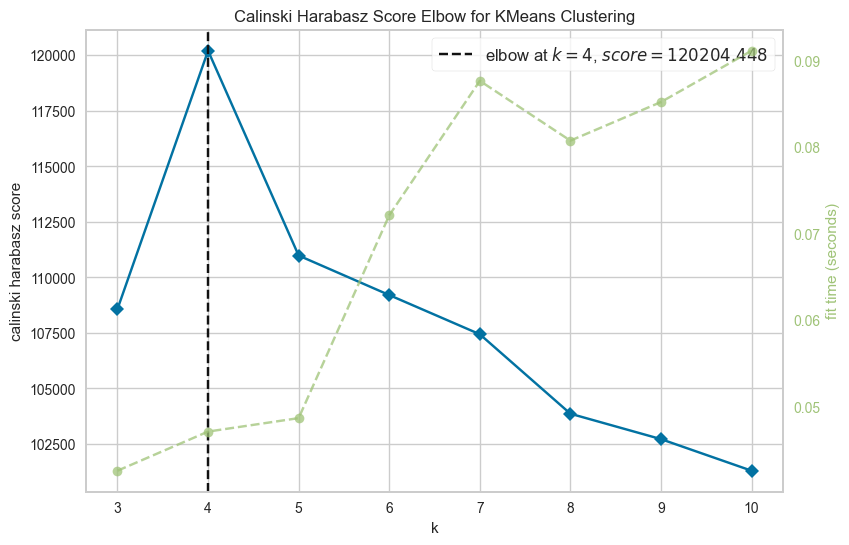

In [41]:
# Graphique KElbowVisualizer Calinski-Harabasz, k compris entre 3 et 10
plot_kelbowvisualizer_kmeans(random_state=0, k=(3, 11), metric='calinski_harabasz', X=X)

* La méthode de Calinski Harabasz indique un nombre optimal de **4 clusters** de manière très nette

* Une segmentation en 3 clusters n'apporterait pas suffisament de précision aux équipes Marketing d'Olist
* Les prochains tests se feront avec 4 et 5 clusters

## 4.2 Entrainement du modèle - 4 clusters

In [42]:
# Entrainement du modèle et ajout des labels de clusters à 'df_features'
df_features['Cluster'] = fit_kmeans(X, 4, random_state=0)

### 4.2.1 Affichage des résultats

In [43]:
# Affichage du résultat
display(df_features)

,Id client,Récence_orig,Fréquence_orig,Montant_orig,Récence,Fréquence,Montant,Montant_log,Montant_qt,Cluster
0,0000366f3b9a7992bf8c76cfdf3221e2,113,0,141.90,0.184692,0,0.636131,0.363304,0.636131,2
1,0000b849f77a49e4a4ce2b2a4ca5be3f,116,0,27.19,0.189684,0,0.021178,0.136688,0.021178,2
2,0000f46a3911fa3c0805444483337064,539,0,86.22,0.893511,0,0.398488,0.294376,0.398488,3
3,0000f6ccb0745a6a4b88665a16c9f078,323,0,43.62,0.534110,0,0.118413,0.200801,0.118413,0
4,0004aac84e0df4da2b147fca70cf8255,290,0,196.89,0.479201,0,0.777711,0.408757,0.777711,0
...,...,...,...,...,...,...,...,...,...,...
95116,fffcf5a5ff07b0908bd4e2dbc735a684,449,0,2067.42,0.743760,0,0.993256,0.736404,0.993256,3
95117,fffea47cd6d3cc0a88bd621562a9d061,264,0,84.58,0.435940,0,0.388941,0.291726,0.388941,0
95118,ffff371b4d645b6ecea244b27531430a,570,0,112.46,0.945092,0,0.518331,0.331096,0.518331,3
95119,ffff5962728ec6157033ef9805bacc48,121,0,133.69,0.198003,0,0.605161,0.355043,0.605161,2


### 4.2.2 Analyse des clusters

#### 4.2.2.1 Répartition des clients par cluster

,Cluster,Id client,%
0,0,34790,36.57
1,1,2900,3.05
2,2,35604,37.43
3,3,21827,22.95


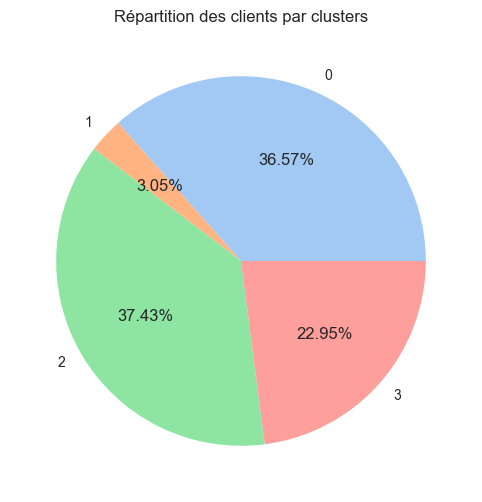

In [44]:
# Nombre de clients par clusters
df_number_of_customers_by_clusters = df_features.groupby('Cluster')['Id client'].count().reset_index()

# Ajout pourcentages
number_of_customers = df_features.shape[0]
df_number_of_customers_by_clusters['%'] = round((df_number_of_customers_by_clusters['Id client'] / number_of_customers) * 100, 2)
display(df_number_of_customers_by_clusters)

# Graphique de répartition
colors = sns.color_palette('pastel')[0:5]
plt.title('Répartition des clients par clusters')
plt.pie(df_number_of_customers_by_clusters['Id client'], labels=df_number_of_customers_by_clusters['Cluster'], colors = colors, autopct='%.2f%%')
plt.show()

* La répartition est relativement homogène, avec 1 cluster moins peuplé  

#### 4.2.2.2 Distributions des features par cluster

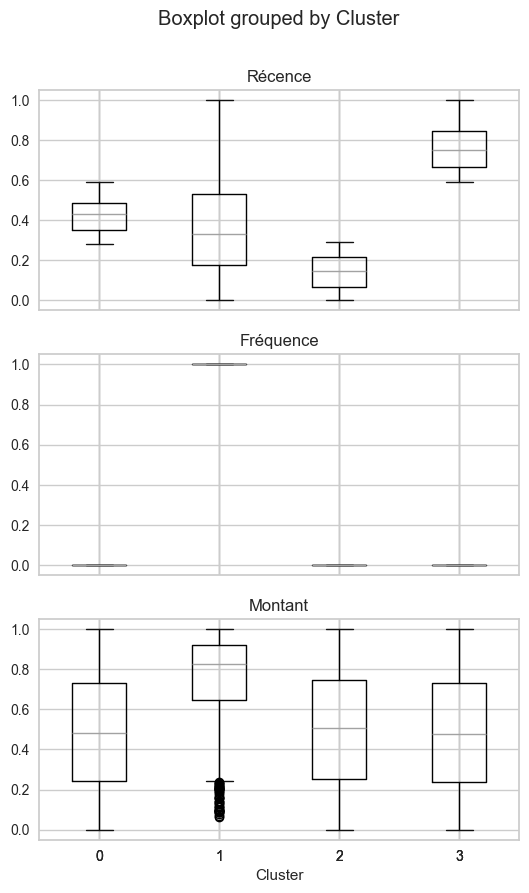

In [45]:
# Boxplots 
boxplots = df_features.boxplot(column=['Récence', 'Fréquence', 'Montant'], by='Cluster', grid=True, figsize=(6, 10), layout=(3, 1))

* Aucune segmentation ne se fait en fonction des montants dépensés, cette segmentation avec **4 clusters** n'est pas efficace

## 4.3 Entrainement du modèle - 5 clusters

In [62]:
# Entrainement du modèle et ajout des labels de clusters à 'df_features'
k = 5
df_features['Cluster'] = fit_kmeans(X, 5, random_state=0)

### 4.3.1 Affichage des résultats

In [63]:
# Affichage du résultat
display(df_features)

,Id client,Récence_orig,Fréquence_orig,Montant_orig,Récence,Fréquence,Montant,Montant_log,Montant_qt,Cluster
0,0000366f3b9a7992bf8c76cfdf3221e2,113,0,141.90,0.184692,0,0.636131,0.363304,0.636131,2
1,0000b849f77a49e4a4ce2b2a4ca5be3f,116,0,27.19,0.189684,0,0.021178,0.136688,0.021178,2
2,0000f46a3911fa3c0805444483337064,539,0,86.22,0.893511,0,0.398488,0.294376,0.398488,3
3,0000f6ccb0745a6a4b88665a16c9f078,323,0,43.62,0.534110,0,0.118413,0.200801,0.118413,0
4,0004aac84e0df4da2b147fca70cf8255,290,0,196.89,0.479201,0,0.777711,0.408757,0.777711,0
...,...,...,...,...,...,...,...,...,...,...
95116,fffcf5a5ff07b0908bd4e2dbc735a684,449,0,2067.42,0.743760,0,0.993256,0.736404,0.993256,3
95117,fffea47cd6d3cc0a88bd621562a9d061,264,0,84.58,0.435940,0,0.388941,0.291726,0.388941,0
95118,ffff371b4d645b6ecea244b27531430a,570,0,112.46,0.945092,0,0.518331,0.331096,0.518331,3
95119,ffff5962728ec6157033ef9805bacc48,121,0,133.69,0.198003,0,0.605161,0.355043,0.605161,2


### 4.3.2 Analyse des clusters

#### 4.3.2.1 Répartition des clients par cluster

,Cluster,Id client,%
0,0,25951,27.28
1,1,2900,3.05
2,2,29230,30.73
3,3,20788,21.85
4,4,16252,17.09


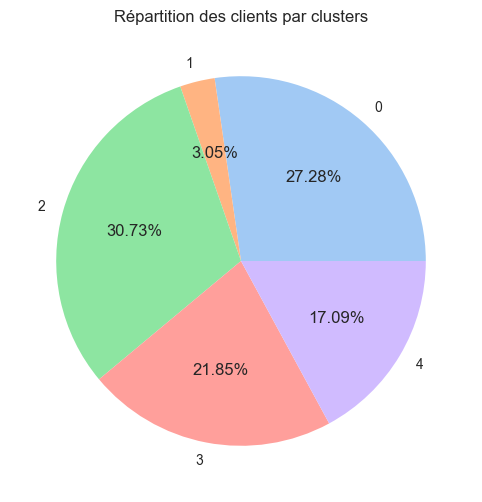

In [64]:
# Nombre de clients par clusters
df_number_of_customers_by_clusters = df_features.groupby('Cluster')['Id client'].count().reset_index()

# Ajout pourcentages
number_of_customers = df_features.shape[0]
df_number_of_customers_by_clusters['%'] = round((df_number_of_customers_by_clusters['Id client'] / number_of_customers) * 100, 2)
display(df_number_of_customers_by_clusters)

# Graphique de répartition
colors = sns.color_palette('pastel')[0:5]
plt.title('Répartition des clients par clusters')
plt.pie(df_number_of_customers_by_clusters['Id client'], labels=df_number_of_customers_by_clusters['Cluster'], colors = colors, autopct='%.2f%%')
plt.show()

* La répartition est relativement homogène, avec maintenant 1 cluster moins peuplé  

#### 4.3.2.2 Distributions des features par cluster

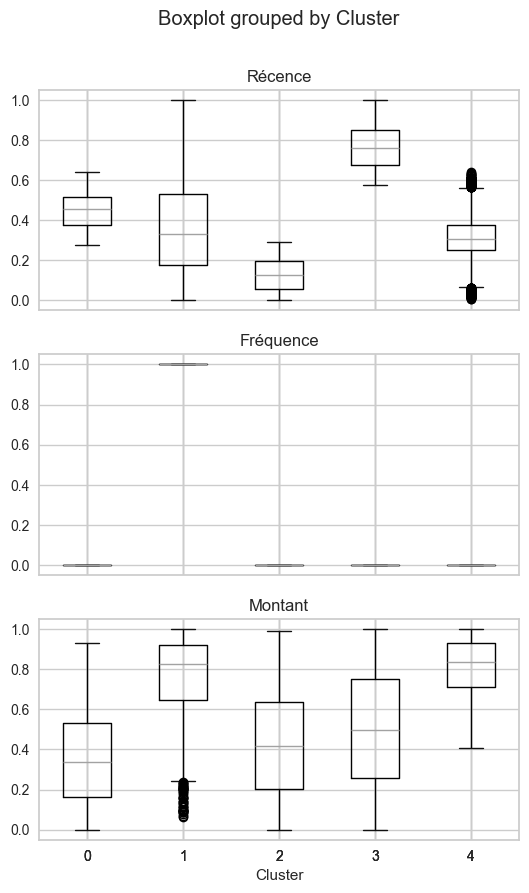

In [65]:
# Boxplots 
boxplots = df_features.boxplot(column=['Récence', 'Fréquence', 'Montant'], by='Cluster', grid=True, figsize=(6, 10), layout=(3, 1))

* Aucune segmentation ne se fait en fonction des montants dépensés, cette segmentation avec **5 clusters** n'est pas plus efficace

## 4.3 KMeans avec 4, 5, 6 ou 8 clusters

* Tests de répartition des montants entre les clusters, pour 4, 5, 6 ou 8 clusters

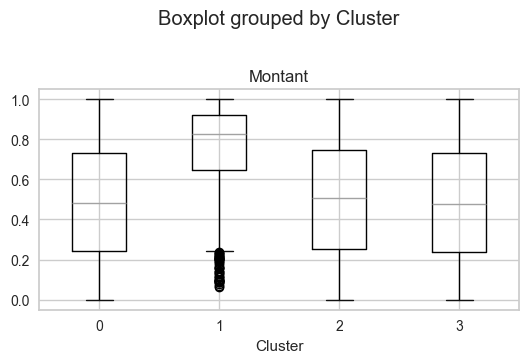

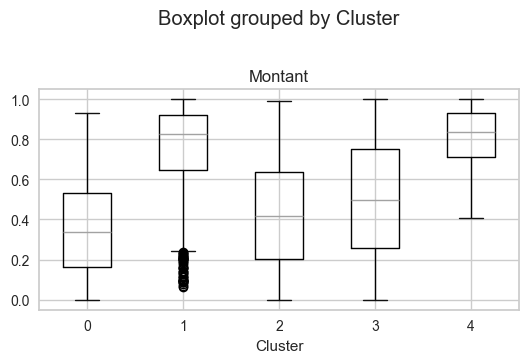

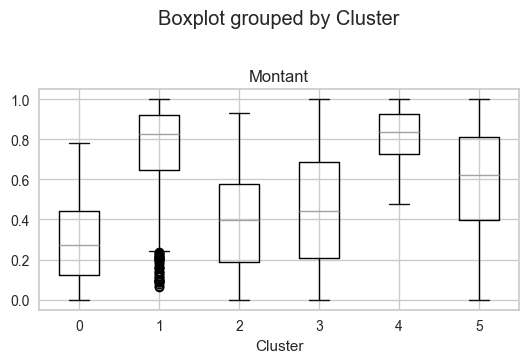

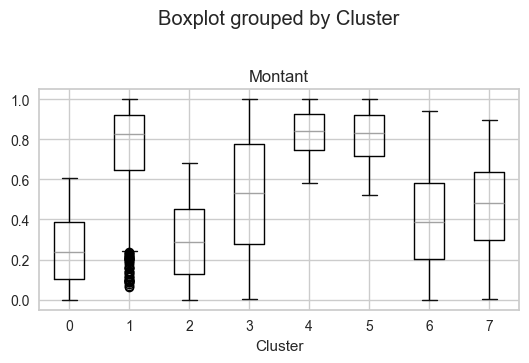

In [66]:
for k in (4, 5, 6, 8):
    df_features['Cluster'] = fit_kmeans(X, k, random_state=0)
    boxplots = df_features.boxplot(column='Montant', by='Cluster', grid=True, figsize=(6, 10), layout=(3, 1))

* Le nombre de clusters semble ne pas avoir d'influence, les chevauchements persistent
* Ces tests confirment les mauvais résultats obtenus après normalisation par quantiles de la varianle `Montant`

# 5 Quatrième test KMeans - Feature `Montant` classée par tranches

In [50]:
# Prise en compte de la version de `Montant`
df_features['Montant'] = df_features['Montant_class']

## 5.1 Détermination du nombre optimal de clusters

### 5.1.1 Elbow Method

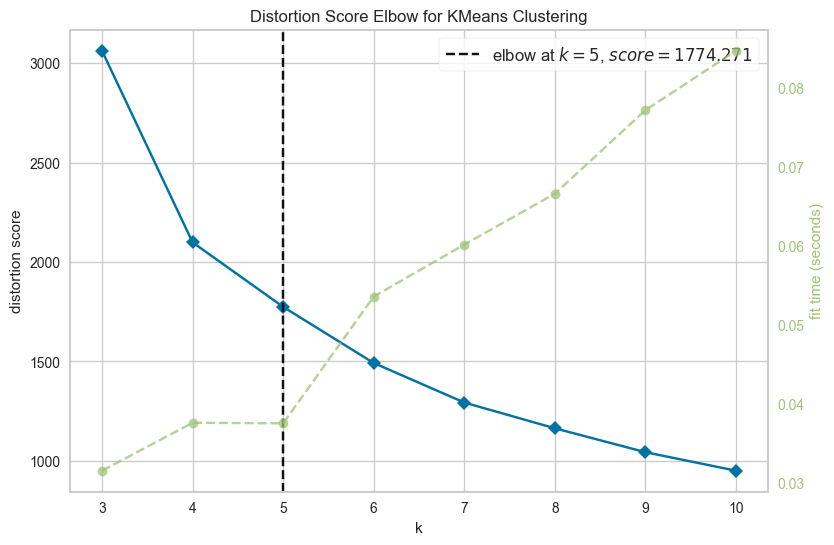

In [51]:
# Graphique KElbowVisualizer Calinski-Harabasz, k compris entre 3 et 10
plot_kelbowvisualizer_kmeans(random_state=0, k=(3, 11), metric='distortion', X=X)

### 5.1.2 Scores de Silhouette

In [52]:
# Affichage du tableau des scores de silhouette pour k compris ente 3 et 10
silhouette_k = display_silhouette_scores(X, random_state=0, k_values=range(3, 11))

,Score de Silhouette
k,
3,0.492181
4,0.414738
5,0.379735
6,0.351411
7,0.346011
10,0.342225
9,0.340674
8,0.335504


* La méthode des scores de Silhouette indique un nombre optimal de clusters de **3**

### 5.1.3 Calinski-Harabasz

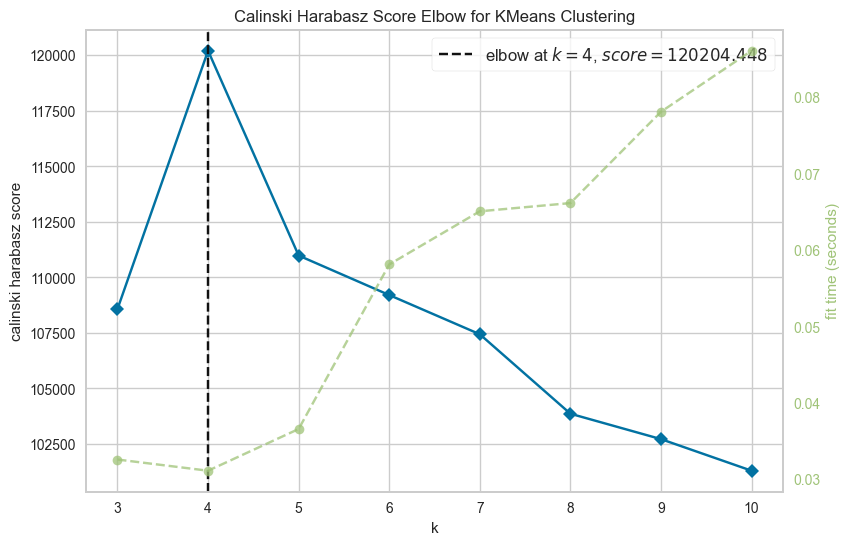

In [53]:
# Graphique KElbowVisualizer Calinski-Harabasz, k compris entre 3 et 10
plot_kelbowvisualizer_kmeans(random_state=0, k=(3, 11), metric='calinski_harabasz', X=X)

* La méthode de Calinski Harabasz indique un nombre optimal de **4 clusters** de manière très nette

* Une segmentation en 3 clusters n'apporterait pas suffisament de précision aux équipes Marketing d'Olist

### 5.1.4 Segmentation des features pour 4, 5, 6, 7 ou 8 clusters

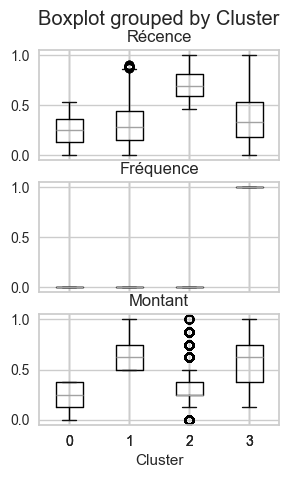

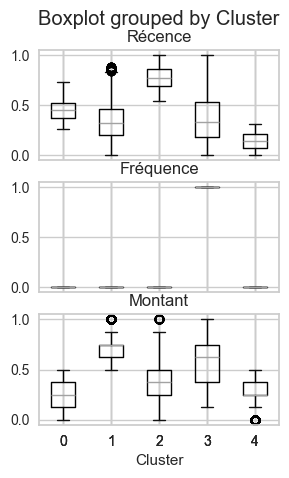

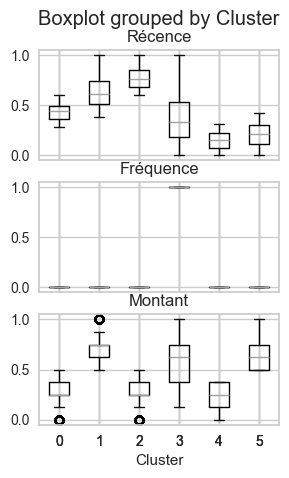

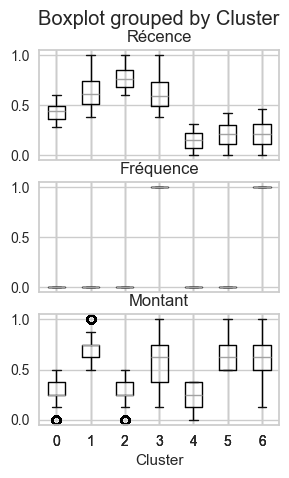

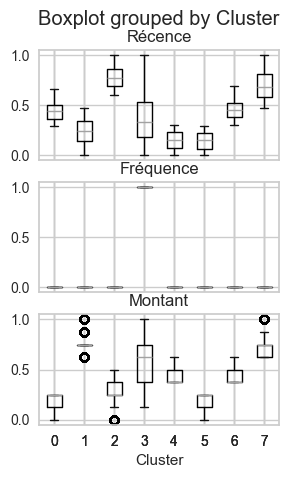

In [54]:
X = df_features[['Récence', 'Fréquence', 'Montant']]

for k in (4, 5, 6, 7, 8):
    df_features['Cluster'] = fit_kmeans(X, k, random_state=0)
    boxplots = df_features.boxplot(column=['Récence', 'Fréquence', 'Montant'], by='Cluster', grid=True, figsize=(3, 5), layout=(3, 1))

* La segmentation en **6 clusters** parait avoir du sens 

## 5.2 KMeans 6 clusters

### 5.2.1 Distributions des features RFM par clusters

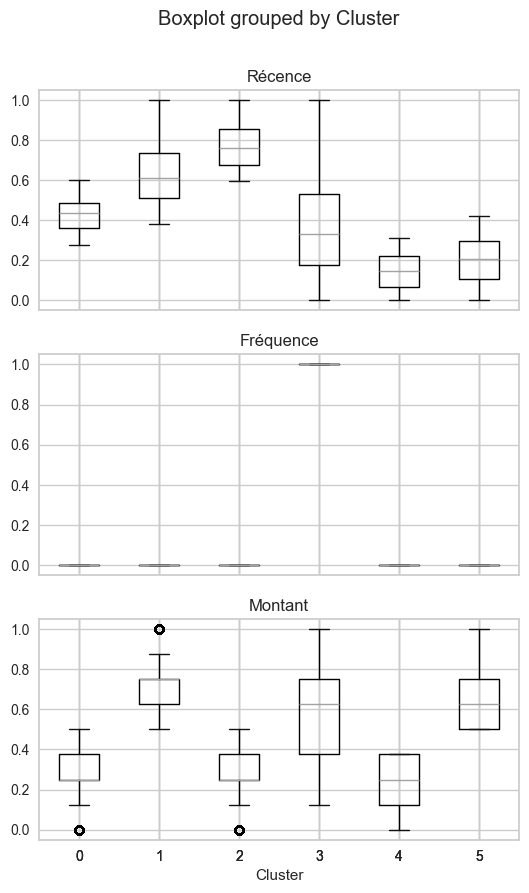

In [55]:
k = 6
df_features['Cluster'] = fit_kmeans(X, k, random_state=0)
boxplots = df_features.boxplot(column=['Récence', 'Fréquence', 'Montant'], by='Cluster', grid=True, figsize=(6, 10), layout=(3, 1))

### 5.2.3 Interprétations

* Tableau récapitulatif des caractéristisques statistiques de chaque cluster

In [56]:
# Calcul des récences en mois
df_features['Récence_mois_orig'] = round(df_features['Récence_orig'] / 30)

# Liste des features à analyser
features_to_analyze = ['Récence_mois_orig', 'Fréquence_orig', 'Montant_orig']

# Création du dictionnaire d'agrégation
aggregations = {feature: ['min', 'max', 'mean', 'median'] for feature in features_to_analyze}
aggregations['Id client'] = 'count'

# Aggrégation des données
cluster_summary = df_features.groupby('Cluster').agg(aggregations)

# Calcul du pourcentage
cluster_summary['Percentage'] = (cluster_summary['Id client']['count'] / df_features['Id client'].count()) * 100

# Affichage des statistiques
display(cluster_summary)

Récence_mois_orig                         Fréquence_orig           \
                      min   max       mean median            min max mean   
Cluster                                                                     
0                     6.0  12.0   8.652712    9.0              0   0  0.0   
1                     8.0  20.0  12.722572   12.0              0   0  0.0   
2                    12.0  20.0  15.418742   15.0              0   0  0.0   
3                     0.0  20.0   7.420000    7.0              1   1  1.0   
4                     0.0   6.0   2.997244    3.0              0   0  0.0   
5                     0.0   8.0   4.105457    4.0              0   0  0.0   

               Montant_orig                                Id client  \
        median          min       max        mean   median     count   
Cluster                                                                
0          0.0        10.07    199.95   86.878095   79.520     25440   
1          0.0       150.00  13664.08  382.927489  266.985     10482   
2          0.0        11.63    199.98   84.997761   77.570     15783   
3          1.0        34.97   7571.63  310.503124  225.760      2900   
4          0.0         9.59    149.89   78.452784   73.610     23950   
5          0.0       150.00   7274.88  328.459254  226.105     16566   

        Percentage  
                    
Cluster             
0        26.744883  
1        11.019649  
2        16.592551  
3         3.048748  
4        25.178457  
5        17.415713

#### 5.2.3.1 Cluster 0 : les clients occasionnels

* Regroupe 27 % des clients  
* Ils n'ont passé qu'1 seule commande, il y a plus de 6 mois et moins d'1 an  
* Ils ont dépensé moins de 200 réals, 50 % des clients de ce segment ont dépensé moins de 80 réals

#### 5.2.3.2 Cluster 1 : les clients à fort potentiel

* Regroupe 11 % des clients
* Ils n'ont passé qu'une seule commande, qui date de plus de 8 mois
* Ils ont dépensé plus de 150 réals, 50 % des clients de ce segment ont dépensé plus de 265 réals  

#### 5.2.3.3 Cluster 2 : les clients dormants

* Regroupe 17 % des clients
* Ils n'ont passé qu'une seule commande, qui date de plus d'1 an
* Ils ont dépensé moins de 200 réals, 50 % des clients de ce segment ont dépensé moins de 78 réals   

#### 5.2.3.4 Cluster 3 : les clients fidèles

* Regroupe 3 % des clients
* Ils ont passé plusieurs commandes, qui se répartissent sur toute la période
* Ils ont dépensé jusqu'à 7500 réals, avec une moyenne de 310 réals
* 50 % des clients de ce segment ont dépensé plus de 225 réals

#### 5.2.3.5 Cluster 4 : les nouveaux clients

* Regroupe 25 % des clients
* Ils n'ont passé qu'une seule commande, il y a moins de 6 mois
* Ils ont dépensé moins de 150 réals, 50 % des clients de ce segment ont dépensé moins de 75 réals  

#### 5.2.3.6 Cluster 5 : les clients prometteurs

* Regroupe 17 % des clients
* Ils n'ont passé qu'une seule commande, il y a moins de 8 mois
* Ils ont dépensé plus de 150 réals, 50 % des clients de ce segment ont dépensé plus de 225 réals  

#### 5.2.3.6 Tentative de représentation graphique - A RETRAVAILLER

In [57]:
df_summary = df_features.groupby('Cluster').agg(
    Récence = ('Récence_mois_orig', 'mean'),
    Fréquence = ('Fréquence', 'min'),
    Montant = ('Montant_orig', 'median'),
    Nb_clients = ('Id client', 'count')
).reset_index()

In [58]:
clusters = {
    0: 'Occasionnels',
    1: 'A fort potientel',
    2: 'Dormants',
    3: 'Fidèles',
    4: 'Nouveaux',
    5: 'Prometteurs'
}

for cluster, cluster_name in clusters.items():
    df_summary.loc[df_summary['Cluster'] == cluster, ['Clients']] = cluster_name

In [59]:
number_of_customers = df_summary['Nb_clients'].sum()
df_summary['Pourcentage de clients'] = round((df_summary['Nb_clients'] / number_of_customers) * 100, 0)

In [60]:
display(df_summary)

,Cluster,Récence,Fréquence,Montant,Nb_clients,Clients,Pourcentage de clients
0,0,8.652712,0,79.520,25440,Occasionnels,27.0
1,1,12.722572,0,266.985,10482,A fort potientel,11.0
2,2,15.418742,0,77.570,15783,Dormants,17.0
3,3,7.420000,1,225.760,2900,Fidèles,3.0
4,4,2.997244,0,73.610,23950,Nouveaux,25.0
5,5,4.105457,0,226.105,16566,Prometteurs,17.0


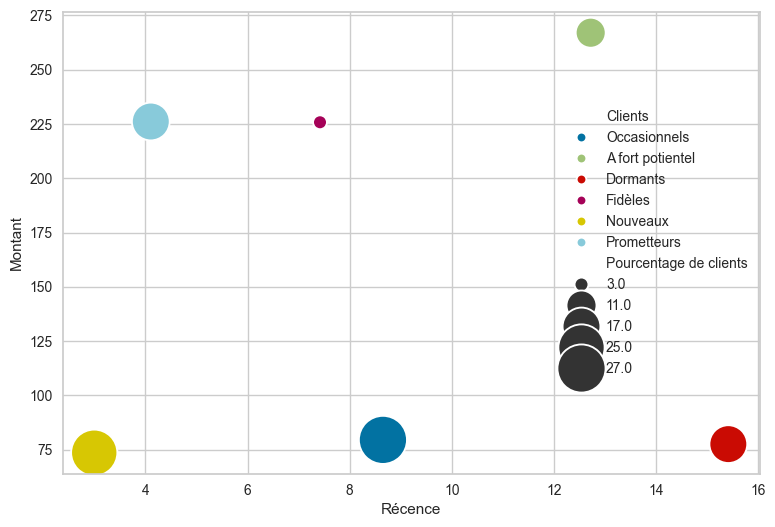

In [61]:
sns.scatterplot(data=df_summary, x='Récence', y='Montant', size='Pourcentage de clients', hue='Clients', sizes=(100, 1200))
plt.show()

# 6 Test DBSCAN

* DBSCAN (Density-Based Spatial Clustering of Applications with Noise) est un algorithme de clustering  
* Il forme des clusters en fonction de la densité des points dans un espace, il n'est pas basé sur la distance comme KMeans
* Il se distingue par sa capacité à trouver des clusters de formes arbitraires
* DBSCAN est capable de détecter et d'isoler les points de bruit (outliers), qui ne font partie d'aucun cluster

## 6.1 Préparation du dataset

* DBSCAN nécessite des features d'entrées normalisées, ce qui est le cas du dasaset présent
* DBSCAN peut monopiliser beaucoup de ressources, il est donc préférable de créer un **échantillon de données** pour les premiers tests, avant de les appliquer à l'ensemble du dataset  

### 6.1.1 Préparation d'un dataframe spécifique

In [207]:
# Récupération des features utiles
df_features_dbscan = df_features[['Id client', 'Récence_orig', 'Récence_mois_orig', 'Fréquence_orig', 'Montant_orig', 'Récence', 'Fréquence', 'Montant']]

In [208]:
# Sélection des features pour le clustering
X = df_features_dbscan[['Récence', 'Fréquence', 'Montant']]

### 6.1.2 Échantillonage

* Seulement 3% des clients ont commandé plus d'une fois, il ne faudrait pas que l'échantillonage passe à côté de ces 3%
* La méthode `StratifiedShuffleSplit` de scikit-learn permet de s'assurer que la proportion des classes est maintenue dans l'échantillon 

In [209]:
# Instanciation
stratified_shuffle_split = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=0)

# Récupération de l'échantillon
for _, sample_index in stratified_shuffle_split.split(X, X['Fréquence']):
    sample_set = X.loc[sample_index]

## 6.2 Recherche des hyperparamètres optimaux

**DBSCAN** repose sur 2 hyperparamètres :  
* **eps** (epsilon) : distance maximale entre deux points pour qu'ils soient considérés comme dans le même voisinage
* **min_samples** : nombre de points nécessaires pour former un cluster dense

### 6.2.1 Epsilon

* Scikit-learn met à disposition la classe `NearestNeighbors` qui  calcule la distance au plus proche voisin de chaque point dans un échantillon de données
* En triant et en traçant ces distances, il est possible d'observer où la courbe commence à augmenter fortement
* Ce point est considéré comme le "coude" et peut donner une bonne estimation pour espilon  

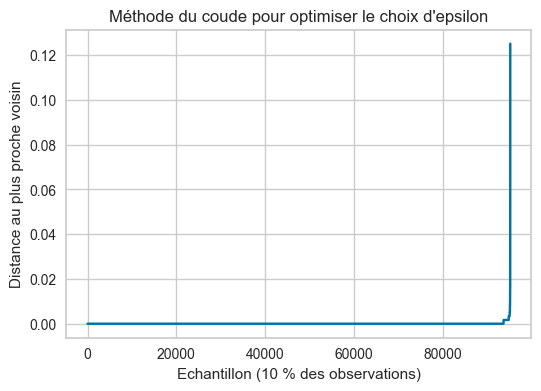

In [152]:
# Affichage de la courbe des distances et récupération de la distance maximale
epsilon_max = plot_elbow_nearest_neighbors(X)

In [171]:
# Distance maximale
print(f"Distance maximale entre 2 points : {epsilon_max}")

Distance maximale entre 2 points : 0.12501107367595612


* Chaque point ne se situant pas à une distance <= epsilon d'un autre point, sera considéré pas DBSCAN comme du bruit, et ne se verra pas attribuer de cluster
* Il n'est pas question qu'un grand nombre de clients n'appartiennent à aucun segment
* Le choix de l'hyperparamètre **eps** ne peut donc qu'être dans les plus hautes valeurs possibles, pour minimiser le bruit :
   * Avec un minimum de **0.10** on peut espérer un bruit minimum
   * Il sera par ailleurs inutile de tester **eps** au-delà de **0.125**

### 6.2.2 Min_samples

* L'hyperparamètre **`min_samples`** détermine le nombre de point minimum pour former un cluster
* Pour une segmentation efficace de la clientèle il ne faut pas avoir de trop petits segments
* Cependant, dans le cas présent, il est intéressant de pouvoir distinguer les clients ayant passé plus d'une commande des autres
* Il y a exactement **2 900** clients n'ayant passé qu'une commande dans le dataset complet, soit environ **290** sur l'échantillon `sample_set` (10 % du dataset)  
* En fixant **`min_samples`** à **250**, cette contrainte devrait être respectée, même si `StratifiedShuffleSplit` n'avait pas respecté la proportion exacte de la feature `Fréquence`

### 6.2.3 Tests des hyperparamètres

In [ ]:
# Plages de paramètres 'eps'
eps_values = np.arange(0.1, 0.125, 0.0005)

# Valeur 'min_samples'
min_samples_value = 250

# Stockage des résultats
results = []

* Il n'existe pas de mécanisme comparable à `GridSearchCV` applicable à DBSCAN, mais cela peut être simuler en bouclant sur une plage de valeurs possibles pour **eps**
* Le Score de Silhouette sera utlisé pour mesurer la peformance de la segmentation

In [ ]:
# Boucle sur les valeurs d'epsilon
for eps in eps_values:
    # Application du modèle DBSCAM sur l'échantillon
    dbscan = DBSCAN(eps=eps, min_samples=min_samples_value).fit(sample_set[['Récence', 'Fréquence', 'Montant']])
    # Récupération des labels de clusters
    labels = dbscan.labels_
    
    # Calcul du score de silhouette, sauf si tous les points sont considérés comme du bruit
    if len(set(labels)) > 1:
        silhouette_avg = silhouette_score(sample_set[['Récence', 'Fréquence', 'Montant']], labels)
    else:
        silhouette_avg = -1
    
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise_ = list(labels).count(-1)

    # Stockage des résultats
    results.append((eps, min_samples, n_clusters_, n_noise_, silhouette_avg))

* Affichage des 5 meilleurs résultats

In [173]:
# Conversion des résultats en dataframe
results_df = pd.DataFrame(results, columns=['eps', 'min_samples', 'n_clusters', 'n_noise', 'silhouette_score'])
results_df.sort_values(by='silhouette_score', ascending=False, inplace=True)

# Affichage des 5 meilleurs résultats
display(results_df.head(5))

,eps,min_samples,n_clusters,n_noise,silhouette_score
46,0.1230,250,5,1962,0.040305
45,0.1225,250,5,1962,0.040305
44,0.1220,250,5,1962,0.040305
43,0.1215,250,5,1962,0.040305
41,0.1205,250,5,1971,0.039737


* Le meilleur résultat est obtenu avec **eps = 0.123** :
   * DBSCAN segmente le dataset en **5 clusters**
   * **1 962** points sont considérés comme du bruit, soit **2.05 %** des clients
   * Le score de Silhouette est très faible (**0.04**), indiquant une très faible perfomance du clustering : les clusters peuvent présenter des chevauchements significatifs
* Les résultats obtenus sont relativement stables sur la plage d'epsilon testée

## 6.3 Résultats DBSCAN

* Malgré un Score de Silhouette faible et un nombre de point de bruit important, il est intéressant d'appliquer ces hyperparamètres à un clustering DBSCAN sur les données d'Olist pour vérifier la manière dont sont constitués les clusters

### 6.3.1 Sur l'échantillon

* Application du modèle

In [210]:
# Lancement DBSCAN
n_clusters, n_noise, labels = fit_dbscan(sample_set, epsilon=0.123, min_samples=250)

In [211]:
# Ajout des labels de cluster au dataframe original
sample_set['Cluster'] = labels

In [212]:
# Affichages nombre de clusters et de points de bruit
print(f'Nombre estimé de clusters: {n_clusters}')
print(f'Nombre estimé de points de bruit: {n_noise}')

Nombre estimé de clusters: 5
Nombre estimé de points de bruit: 1962


* Répartition des features RFM par clusters

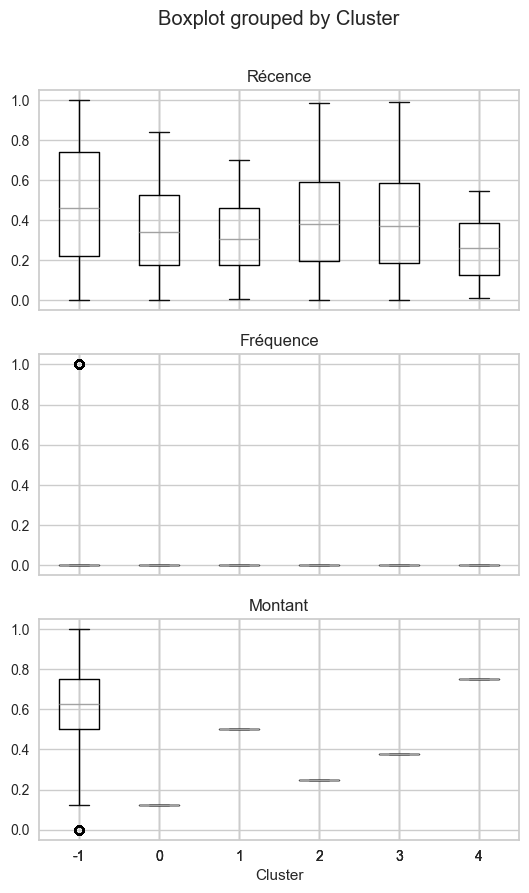

In [214]:
boxplots = sample_set.boxplot(column=['Récence', 'Fréquence', 'Montant'], by='Cluster', grid=True, figsize=(6, 10), layout=(3, 1))

* Sans surprise au regard des Score de Silhouette, le clustering DBSCAN ne fonctionne pas sur le dataset
* Le cluster labelisé **-1** correspond aux point de bruits
* L'agorithme n'a pas pu isoler les clients ayant passé plusieurs commandes (`Fréquence` à 1)
* Les chevauchements sur la variable `Récence` sont très importants
* Le clustering semble se faire uniquement sur des montants identiques ou très proches, qui ne couvre pas du tout la plage des possibilités

### 6.3.1 Sur le dataset complet

* Puisque l'échantillon était composé de 10 % du dataset, le paramètre `min_samples` doit être ajusté à **2500**

In [215]:
# Lancement DBSCAN
n_clusters, n_noise, labels = fit_dbscan(df_features_dbscan[['Récence', 'Fréquence', 'Montant']], epsilon=0.123, min_samples=2500)

In [218]:
# Ajout des labels de cluster au dataframe original
df_features['Cluster DBSCAN'] = labels

In [219]:
# Affichages nombre de clusters et de points de bruit
print(f'Nombre estimé de clusters: {n_clusters}')
print(f'Nombre estimé de points de bruit: {n_noise}')

Nombre estimé de clusters: 5
Nombre estimé de points de bruit: 18748


* Répartition des features RFM par clusters

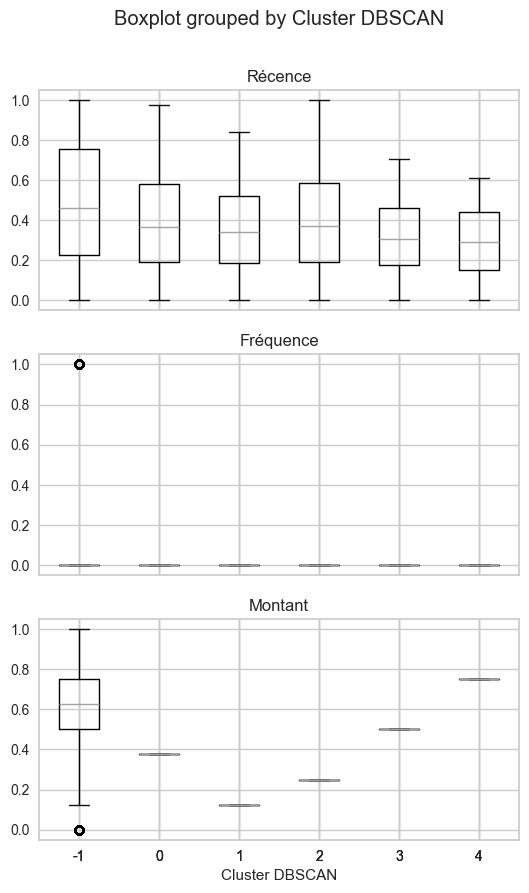

In [220]:
boxplots = df_features.boxplot(column=['Récence', 'Fréquence', 'Montant'], by='Cluster DBSCAN', grid=True, figsize=(6, 10), layout=(3, 1))

* Les résultats sont identiques, hormis le nombre de points de bruits qui passe de **1 962** sur l'échantillon à **18 748** sur le dataset complet, soit environ 10 fois plus, ce qui est logique car l'échantillon représentait 10 % du dataset